# Introduction

Often when applying NLP to real life problems, we find that every organisation has a lot of unstructured data lying around, not being used anywhere. But including NLP based features on traditional Prediction problems can bring in fresh perspectives that are not obtained looking through structured data alone. How can we find out if the unstructured data has something useful? What are some of the basic steps that you need to find what information your data holds? This is very different from the NLP based problems like entities, summarisation, text generation etc. This notebook talks about some basic steps in which we can use the unstructured data and create new features.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:

import matplotlib.pyplot as plt
import itertools
from wordcloud import WordCloud, STOPWORDS


plt.figure(figsize=(20,12))
figsize=(12,5)

In [ ]:
tweets_df = pd.read_csv('/kaggle/input/tweets-of-us-senators/senators.csv')

In [ ]:
#Exploring the tweets
print(tweets_df.shape)
tweets_df.head()

# Understanding your columns 



In [ ]:
tweets_df.info()

This dataset has about 9 columns and none of them have any null values. The Replies, Retweets, Favorites columns are integers while all other columns are text. In Structured Data as a next step we could do df.describe() to understand the distribution of your values. But here i am gonna skip them as there are only 3 integer columns

"Text" is the major attribute in this dataset. We will try to understand how the Text Distribution varies w.r.t all the other attributes. Here we will ignore URL cause it does not convey any meaning. I am skipping Bio_Guide_Id as well cause it looks like the Bio Guide Id and User convey the same meaning. 

# Feature Understanding

## Created At

In [ ]:
tweets_df['created_at']= pd.to_datetime(tweets_df['created_at'])
print("First tweet was done at", tweets_df['created_at'].min())
print("The latest tweet is ", tweets_df['created_at'].max())

## Feature Addition - Activity

Instead of individually looking at the replies, retweets, favorites- I am going to add all of them and create a new feature called Activity. Any activity is an indication of interest generation. Now if we want we could assign weightages as well - like Favorite could have more weightage than Retweet. But I am going for a simple sum.

In [ ]:
tweets_df['activity'] = tweets_df['replies']+tweets_df['favorites']+tweets_df['retweets']

Now the idea is to find the Viral Tweets - i.e the tweets that have gathered more attention than the others. We will use the Pandas Quantile function to acheive this.First I am going to fetch tweets whose activity has been greater than 99.99 % of the other tweets

In [ ]:
#getting the viral tweets - find the value which is greater than 99.99% of the tweets
print(tweets_df['activity'].quantile(0.9999))

Now we will fetch all tweets whose activity has been greater than 600641

In [ ]:
plot_viral = tweets_df.loc[tweets_df['activity']>600641]
print(plot_viral.shape)

So we have 30 tweets which have generated a lot of attention. We could play around with the quantile number. Just going to take a closer look at these viral tweets..

In [ ]:
fig, axes = plt.subplots(ncols=3,figsize=figsize)
plot_viral['user'].value_counts().plot(kind='bar', ax = axes[0],subplots=True)
plot_viral['state'].value_counts().plot(kind='bar',ax = axes[1],subplots=True)
plot_viral['party'].value_counts().plot(kind='bar',ax = axes[2],subplots=True)

It looks like Vermont has most number of popular tweets more than NY.SenatorLeahy , Senator Sanders have the most number of popular tweets. Democratic party has generated the largest number of viral tweets. Independent has one and Republican has None.

Now we will look at attributes party and state before coming back to User

## Party

Now we will look at attributes party and state before coming back to User. 

In [ ]:
#Exploring the value counts by Party
tweets_df['party'].value_counts()
tweets_df['party'].value_counts().plot(kind='bar')

Even though Republican party has not generated many Viral Tweets, the count of number of tweets by Replublican party is high. 


## State

When analysing tweets by State, we will look at Maps as well

In [ ]:
#Exploring the value counts by State
tweets_df['state'].value_counts()
tweets_df['state'].value_counts().plot(kind='bar',figsize=figsize)

Here we can see that Atlanta has very less tweets. We could probably cluster them into 4 clusters based on the number of tweets. Very large , large, medium, small.

For plotting the details on a map, I have added a new csv called States.csv downloaded from Google to get the latitude and longitude or each state. We can combine both these dataframes using the State column

In [ ]:
states_df = pd.read_csv('/kaggle/input/states-latitude/States.csv', names=['state', 'latitude','longitude', 'desc'])
states_df = states_df[1:]
new_df = tweets_df.merge(states_df, on='state')
new_df.head()

First we will generate a heatmap to understand the distribution of these tweets. Here the Zoom level and radius were set after some trial and error.

In [ ]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
# Create a map
m_1 = folium.Map(location=[37.0902,-95.7129], tiles='cartodbpositron', zoom_start=4)

# Add a heatmap to the base map
HeatMap(data=new_df[['latitude', 'longitude']], radius=50).add_to(m_1)

# Display the map
m_1

Generally the East Coast is more active than the West Coast. 
<br>You could zoom in and out see by States, by area to get some more insights.
I have given an image of how it looks when you zoom in on the East Coast.


Interestingly California is having much lesser Tweets than Seattle
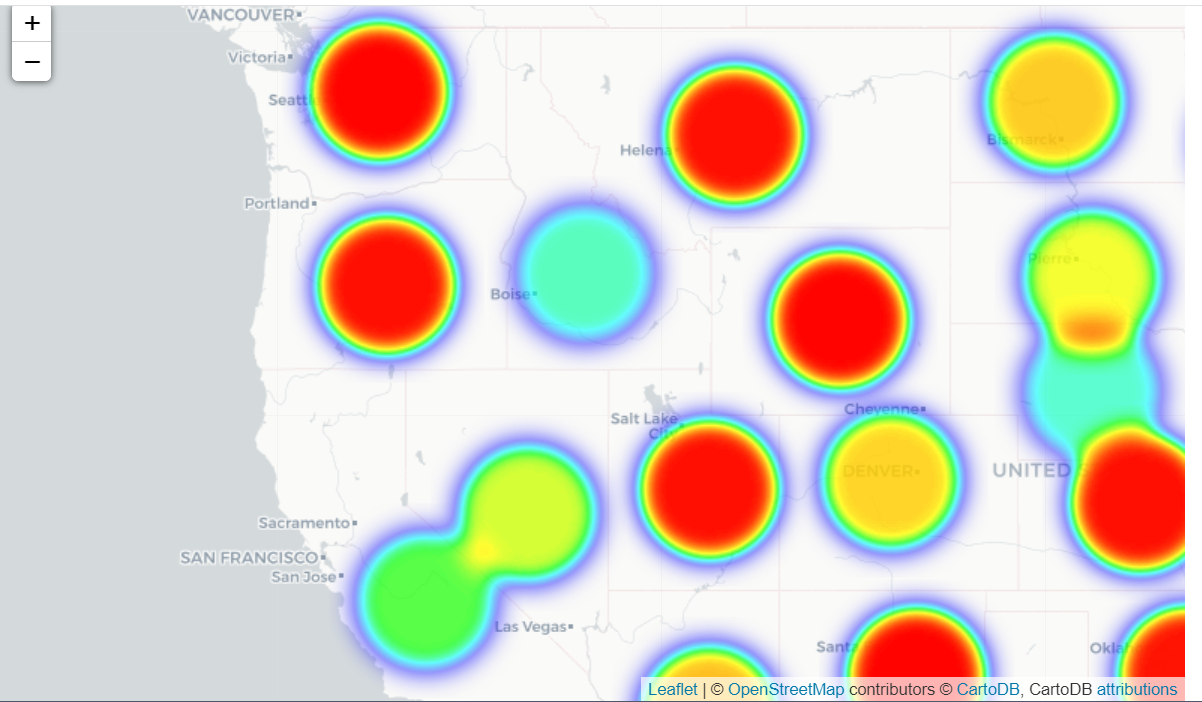

<div class="alert alert-block alert-info">
Here this just a map view of the counts. The below cell takes a pretty long time to load. So If you dont want to run the cell, just look at the image below.
</div>

In [ ]:
# # Create the map
# import math
# m_3 = folium.Map(location=[37.0902,-95.7129], tiles='cartodbpositron', zoom_start=13)

# # Add points to the map
# mc = MarkerCluster()
# for idx, row in new_df.iterrows():
#     mc.add_child(Marker([row['latitude'], row['longitude']]))
# m_3.add_child(mc)

# # Display the map
# m_3

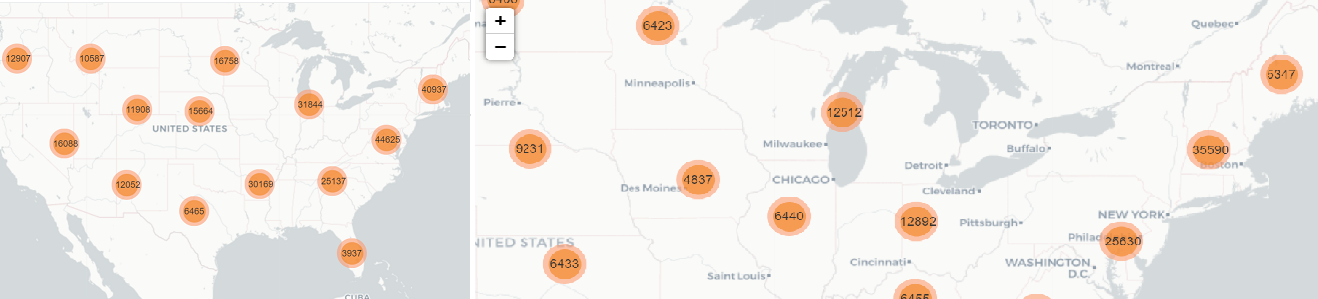
Images of how the graph looks if u did not run the previous cell

## User

We will do a slightly detailed analysis of the tweets w.r.t to user before moving on to the tweets itself.

In [ ]:
tweets_df['user'].unique().size

There are about 100 users. Now let us see the average number of tweet's and the number of times they have tweeted. That can be fetched using the value counts attribute of Pandas.

In [ ]:
tweets_by_user = pd.DataFrame(tweets_df['user'].value_counts())
tweets_by_user.head()

In [ ]:
tweets_by_user.describe()

We can see that the minimum number of tweets by a user is 454 and maximum is 3247 and the mean is 2886. Around 75% of the users tweet more than 3190- that is they are highly active.

Let us see who are the top users who generate a lot of tweets and who are the top users who generate a lot of popular tweets.  For this we will use the nlargest property of pandas. This gives the top 'n' values of a column. Groupby() count() work very similar to any SQL group by.

In [ ]:
user_count_tweets = tweets_df.groupby('user').count()['text']
user_count_tweets.nlargest(25).plot(kind='bar',figsize=figsize)
plt.show()
user_count_tweets = tweets_df.groupby('user').sum()['activity']
user_count_tweets.nlargest(10).plot(kind='bar',figsize=figsize)


While Sanders is not among the most active users he has generated the most popular Tweets. In fact, there are very few names that appear in both section. Senator Kamala Harris has only tweeted 1390 times when compared to many senators who have tweeted like more than 3000 times but she was able to generate a higher activity through her tweets. But one thing to note is that the activity generated by Sanders is much more than the others.

Now we will take a few senators and look at their tweets in detail. First we start off analysing the time period of tweets. Where there any spikes in specific months?

In [ ]:
def senator_analytics(senatorName):
    senator_tweets = tweets_df.loc[tweets_df['user']==senatorName]
    print('The first tweet of Senator Udall is', senator_tweets['created_at'].min())
    print('The last tweet of Senator Udall is', senator_tweets['created_at'].max())
    senator_tweets['month_year']= senator_tweets['created_at'].dt.to_period('M')
    senator_tweets['month_year'].value_counts().plot(kind='bar', figsize=figsize)
    return senator_tweets

In [ ]:
tom_udall_df = senator_analytics('SenatorTomUdall')

Now we can say obviously trend that Tom Udall 2017 had the most tweets, there were periodic spikes in 2016 and 2015 but very little activity before 2013. So we can say that the activity had increased considerably in the recent years.



## NLP

All the above analysis that we did before is simple analysis that we do on a structured data. Now we will go to how to apply NLP onto the above dataset. We will be using Spacy for our data preprocessing activities. First we will have to cleanup the tweet. Given below are some common cleanup activities that we do, but you might have to add more based on your data.

* Capture sequence of words, numbers
* I found a special character �, so removing that.
* RT keyword removal if any
* Remove hyperlinks,references 
* Then #tags
* Finally, we iterate through all words in the tweet and check if it is a punctuation or a stop word and then add the lemma form. This is done so that we can find the common topics tweeted.

Applying this on the whole dataset can take a while and so we will stick to a single senator's tweets and analyse them in detail


In [ ]:
import re
import spacy
nlp = spacy.load('en_core_web_sm')
def preprocessing_tweets(tweet):
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = tweet.replace("�","")
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https:(\/\/t\.co\/([A-Za-z0-9]|[A-Za-z]){10})', '', tweet)
    # remove references
    tweet = re.sub(r'@[\s]+', '', tweet)
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    tokens = nlp(tweet)
    new_tweet = [];
    for token in tokens:
        if not (token.is_punct or token.is_stop or token.text in ['amp']):
            new_tweet.append(token.lemma_)
    return ' '.join(new_tweet)
tom_udall_df['processed_tweet']= tom_udall_df['text'].apply(preprocessing_tweets)

Now we will want to see the top 'n' things that a senator tweeted about. So for that we need to combine all the tweets of a single senator take a counter of words and plot the top 'n' words. Counter returns a dict and hence i am using itertools to slice the top 'n' words.

In [ ]:
enitre_tweets = tom_udall_df['processed_tweet'].tolist()
s='!!'
enitre_tweets = s.join(enitre_tweets)
from collections import Counter
word_count = Counter(enitre_tweets.split( ))
import itertools
#Take the top N items
top_N_dict = dict(itertools.islice(word_count.items(), 15))
top_N_dict= {k: v for k, v in sorted(top_N_dict.items(), key=lambda item: item[1], reverse=True)}
#freq dictionary
print(top_N_dict)
plt.figure(figsize=(20,5))
plt.bar(x=top_N_dict.keys(),height=top_N_dict.values())


Now we will see how to plot a wordcloud.Word cloud is another very quick way to see the top 'n' things that a user is speaking about. We will use the library Word cloud for the same. Word Cloud takes an attribute as Collocation_threshold that is basically the number of words that appear together. This helps us really understand the topics better. We can increase/decrease it to see how the words appear.

In [ ]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10,collocation_threshold=2).generate(enitre_tweets)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Combining both steps to a single method so that we can view them for multiple senators. Now here i have made the field name and the preprocessing fn name as well, so that we can reuse the same function by extracting sub parameters of the tweet.

In [ ]:
def advanced_senator_analytics(senatorName,fieldName='processed_tweet',fn=preprocessing_tweets):
    senator_df = tweets_df.loc[tweets_df['user']==senatorName]
    senator_df[fieldName]= senator_df['text'].apply(fn)
    enitre_tweets = senator_df[fieldName].tolist()
    s='!!'
    enitre_tweets = s.join(enitre_tweets)
    from collections import Counter
    word_count = Counter(enitre_tweets.split( ))
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10,collocation_threshold=2).generate(enitre_tweets)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    #Take the top N items
    top_N_dict = dict(itertools.islice(word_count.items(), 15))
    top_N_dict= {k: v for k, v in sorted(top_N_dict.items(), key=lambda item: item[1], reverse=True)}
    #freq dictionary
    plt.figure(figsize=(20,5))
    plt.bar(x=top_N_dict.keys(),height=top_N_dict.values(),)
    return senator_df
    

In [ ]:
sanders_df = advanced_senator_analytics('SenSanders')

Now we understand what are the main topics that the senator has spoken about. But the problem is there are so many words. Now how do we narrow them down. There are two techniques. Rather than extracting all the words , we could just extract the nouns or any pos tags for that matter .

In [ ]:
def extract_pos(tweet, pos_tags=['NOUN']):
    tweet = re.sub(r'https:(\/\/t\.co\/([A-Za-z0-9]|[A-Za-z]){10})', '', tweet)
    doc = nlp(tweet)
    new_tweet = [];
    for token in doc:
        if token.pos_ in pos_tags and token.text not in ['http','https','httpst','https ','amp']:
            new_tweet.append(token.text)
    return ' '.join(new_tweet)

In [ ]:
advanced_senator_analytics('SenSanders','pos_tweet',extract_pos)

In [ ]:
advanced_senator_analytics('SenKamalaHarris','pos_tweet',extract_pos)

While Senator Sanders talks more about health care. Senator Kamala Harris also speaks about Health care, but there is a lot of mention about women and gender as well. Another way to look at it would be to look at the entities mentioned by ppl. Entities are a word or a chunk of words referring to one single thing and then can be of a type. Say for example, in the sentence,"I want to book a flight from Sydney to Paris". Sydney and Paris are locations, another way to look at it would be Sydney is the source and Paris is the destination. 

Spacy provides ner models for many languages which come with inbuilt entities or you can even train more entities. We will look at inbuilt entities here. Adding new entities is not covered here.




In [ ]:
def extract_entities(tweet):
    tweet = re.sub(r'https:(\/\/t\.co\/([A-Za-z0-9]|[A-Za-z]){10})', '', tweet)
    doc = nlp(tweet)
    new_tweet = [];
    for token in doc.ents:
        if (token.label_ not in ['DATE']):
            new_tweet.append(token.text)
    return ' '.join(new_tweet)

In [ ]:
sanders_df = advanced_senator_analytics('SenSanders','entity_tweet',extract_entities)

Now we will look how to extract the keyphrases using the YAKE library. This library returns a keyword and a score. Please note that lower the score more relevant the score is.

In [ ]:
!pip install YAKE

In [ ]:
import yake
def extract_keywords(tweet):
    language = "en"
    max_ngram_size = 3
    deduplication_threshold = 0.5
    numOfKeywords = 20
    custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
    keywords = custom_kw_extractor.extract_keywords(tweet)
    if len(keywords) > 1 :
        length = 2 if len(keywords) > 1 else 1
        keywords = list(zip(*keywords[:length]))[0]
        return ' '.join (keywords)
    else:
        return ''

In [ ]:
advanced_senator_analytics('SenSanders','key_tweet',extract_keywords)

# Conclusion
Now that we have a lot of information, we could use them in a variety of ways. Suppose we are trying to predict a chance of user wining elections,along with the other features we could also include tweets. We could directly use the count of tweets as feature. We could cluster them based on theier social media activity.Coming to NLP, We could take  top 10/50 - keywords, entities across all users and one hot encode the presence or absence of a keyword. We could cluster users/states based on these new features and user that as one of the features. I am pretty sure there a lot more features that you can think of. I have just listed a few.Hope you are able to apply some of these techniques in you next problem.